# Exploratory Data Analysis & Feature Engineering

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#cleaning">Data Cleaning</a></li>
<li><a href="#feature">Feature Engineering</a></li>
<li><a href="#export">Merge DataFrames and Export</a></li>
</ul>

<a id='intro'></a>
## Introduction
This dataset consists of over 8.5M rows of consumer behavior data across an online cosmetics storefront. Every record contains a unique timestamp corresponding to an action the user took on the site; which includes viewing a product, adding a product to their cart, removing a product from the cart, and purchasing an item.  

The goal for this project is to predict if a customer will make <font color='red'>[their first?]</font> a purchase. To achieve this, all of the features will need to be created to aggregate individual user actions leading up to their purchase.

In [82]:
# import necessary packages
import pandas as pd
import numpy as np
import pickle

import psycopg2 as pg
import pandas.io.sql as pd_sql

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [83]:
# set plot style for visualizations
#plt.style.use('dark_background')
plt.style.use('ggplot')

In [84]:
# set up connection to postgres
connection_args = {
    'host': 'localhost',  
    'dbname': 'events',    
    'port': 5432          
}
connection = pg.connect(**connection_args)

In [85]:
# read in the dataset and label columns
query = "SELECT * FROM all_events;"
df = pd_sql.read_sql(query, connection)
print(df.shape)
df.head()

(8738120, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:35:09,view,5884577,1.487580e+18,appliances.environment.vacuum,max,47.46,509896854,e62d29f3-b14a-4c25-afb0-ddbdea4bcf89
1,2019-10-01 00:35:13,cart,5804354,1.487580e+18,None,bluesky,5.24,489267719,e96af142-3dd6-423f-881d-5d8518ae897e
2,2019-10-01 00:35:20,remove_from_cart,5760772,1.487580e+18,None,runail,2.62,446404021,abac4e23-d977-47d9-99e9-7faf35e62cc1
3,2019-10-01 00:35:21,remove_from_cart,5760772,1.487580e+18,None,runail,2.62,446404021,abac4e23-d977-47d9-99e9-7faf35e62cc1
4,2019-10-01 00:35:27,cart,5773181,1.487580e+18,None,runail,2.62,464191317,3ab4d9ce-82f9-abc8-ae11-e07eed4987ce


The dataset contains 8.7M rows and 9 columns. The data represents individual actions taken by each user throughout each session.

<a id='cleaning'></a>
## Data Cleaning
<ol>
<li><a href="#cosmetics">Non-cosmetics categories</a></li>
<li><a href="#negative">Negatively priced items</a></li>
<li><a href="#remove">Removed from cart</a></li>
<li><a href="#first">One-time visitors</a></li>
</ol>

In [86]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8738120 entries, 0 to 8738119
Data columns (total 9 columns):
event_time       8738120 non-null datetime64[ns]
event_type       8738120 non-null object
product_id       8738120 non-null int64
category_id      8738120 non-null float64
category_code    143225 non-null object
brand            5092830 non-null object
price            8738120 non-null float64
user_id          8738120 non-null int64
user_session     8736670 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 600.0+ MB


There are quite a few null values in the `category_code` column.

In [87]:
df.category_code.value_counts()

appliances.environment.vacuum             59761
stationery.cartrige                       26722
apparel.glove                             18232
furniture.living_room.cabinet             13439
accessories.bag                           11681
furniture.bathroom.bath                    9857
appliances.personal.hair_cutter            1643
accessories.cosmetic_bag                   1248
appliances.environment.air_conditioner      332
furniture.living_room.chair                 308
sport.diving                                  2
Name: category_code, dtype: int64

<a id='cosmetics'></a>
### 1. Non-cosmetics categories

The non-null columns appear to be non-cosmetic. These are assumed to be erroneous data and will be removed from the dataset.

In [88]:
df = df[df.category_code.isnull()]
df.shape

(8594895, 9)

<a id='negative'></a>
### 2. Negatively priced items

Next let's look at the range in product pricing. Gauging propensity to purchase could potentially be pricing based, so it's good to get a sense of the pricing distribution

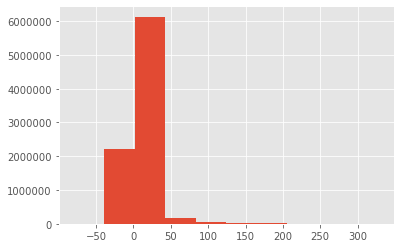

In [89]:
df.price.hist();

There seem to be some items that are priced negatively.

In [90]:
df[df.price < 0]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
111872,2019-10-01 19:10:56,purchase,5716857,1.487580e+18,None,None,-23.81,552507528,dcdd60c6-1a70-442d-bfb2-0252879054ad
197314,2019-10-02 08:30:03,purchase,5716855,1.487580e+18,None,None,-7.94,550375225,5ddec778-9464-4514-914d-be7b751b8e2c
435930,2019-10-03 17:37:04,purchase,5716859,1.487580e+18,None,None,-47.62,555414763,479149eb-1807-4178-8f6b-87c642350735
442216,2019-10-03 18:25:39,purchase,5670257,1.487580e+18,None,None,-15.87,556383221,4333d203-bc4d-4d0d-a6e1-0ea3a97a28c1
1294568,2019-10-09 14:49:14,purchase,5716855,1.487580e+18,None,None,-7.94,514562574,fed2aeb4-0c75-44f7-9ca8-1a8be8214779
1425198,2019-10-10 14:33:29,purchase,5716855,1.487580e+18,None,None,-7.94,558797258,a406cf28-f04b-4361-8e6a-c62d36045e07
1518258,2019-10-11 10:27:19,purchase,5716859,1.487580e+18,None,None,-47.62,543647038,85e11d74-6583-4eab-b50c-ff86dbb25d97
1782324,2019-10-13 16:46:01,purchase,5716857,1.487580e+18,None,None,-23.81,559820267,f178c995-f004-4040-b26d-b1cca0f9657d
1923084,2019-10-14 17:33:24,purchase,5716861,1.487580e+18,None,None,-79.37,541122983,b60f777d-afca-4299-8548-273b810d6130
2142775,2019-10-16 11:41:06,purchase,5716857,1.487580e+18,None,None,-23.81,461943726,beefa8fb-a3d1-48ca-97e9-9c95b05ee997


It looks like each of these events correspond to a customer purchase. These could potentially be returned items. With that in mind, line items with negative purchases will be removed from the dataset.

In [91]:
df = df[df.price > 0]
df.shape

(8577459, 9)

<a id='remove'></a>
### 3. Removed from cart

Next I will look at event types to see what behaviors will be incorporated into the model in order to predict a future purchase.

In [92]:
df.event_type.value_counts()

view                3832727
cart                2512700
remove_from_cart    1671299
purchase             560733
Name: event_type, dtype: int64

The different types of actions captured in the dataset include customer views of each product, adding items to cart, removing items from cart, and purchasing.  

Because my objective is to find customer purchases, I must handle the event types in a way that will not be duplicative. Each action taken by the customer is captured in the data, therefore all rows where a customer purchased a product will also have a row within that same session where the customer added the item to their cart.  

To account for this, counts of occurrences where a customer added an item to their cart should not include sessions where they made a purchase. With this in mind, removals from cart become duplicative and should be removed.

In [93]:
df = df[df.event_type.isin(['view', 'cart', 'purchase'])]
df.shape

(6906160, 9)

<a id='first'></a>
### 4. One-time visitors
One major source of variability in the data I may encounter when predicting future purchases is the presence of one-time visitors. One-time visitors may either buy or leave in their sole visit, which has the potential to throw off the model. Because I am looking to predict the first purchase a user will make, I will need more than one session per user to accurately predict future actions. As such, one-time visitors will be removed from the dataset.

In [94]:
# create dataframe of number of sessions per user, where the user logged more than one session
query = """
SELECT user_id,
       COUNT(user_session)
FROM all_events
GROUP BY 1
HAVING COUNT(user_session) > 1;
"""
one_visit = pd_sql.read_sql(query, connection)
one_visit

,user_id,count
0,1458813,31
1,4103071,8
2,5493470,10
3,8846226,47
4,9478445,4
...,...,...
397853,579963467,2
397854,579964807,3
397855,579964964,2
397856,579966747,18


In [95]:
# filter original dataframe to include only the user IDs found in query
df = df[df.user_id.isin(one_visit.user_id.values)]
df.shape

(6601004, 9)

In [96]:
df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1,2019-10-01 00:35:13,cart,5804354,1.487580e+18,None,bluesky,5.24,489267719,e96af142-3dd6-423f-881d-5d8518ae897e
4,2019-10-01 00:35:27,cart,5773181,1.487580e+18,None,runail,2.62,464191317,3ab4d9ce-82f9-abc8-ae11-e07eed4987ce
6,2019-10-01 00:35:43,cart,5804353,1.487580e+18,None,bluesky,5.24,489267719,e96af142-3dd6-423f-881d-5d8518ae897e
9,2019-10-01 00:35:46,cart,5700164,1.487580e+18,None,None,1.75,554342223,0b974342-1a53-41c1-a426-23130e770f4b
10,2019-10-01 00:35:54,cart,5882773,1.487580e+18,None,runail,3.17,512321151,4a821b26-be03-4dac-8056-c42abe5221c7


### Data Cleaning Summary
1. Remove extraneous product categories (non-cosmetics products)
2. Remove negatively priced items
3. Remove rows with `remove_from_cart`
4. Filter out one-time users

<a id='feature'></a>
## Feature Engineering

### Create Target
The target I am aiming to predict from this dataset is if a customer will make a purchase. The first step is to create a column that turns the "purchase" event into a binary classifier. From there, I can begin engineering other features to predict the event.

In [97]:
# create target column with binary classifier
df['purchased'] = np.where(df['event_type'] == 'purchase', 1, 0)

### Create Modeling Dataset
This approach will use features that are "user-centric," meaning each line item will hold values for unique users. Each feature will contain roll-ups of that user's activity throughout the time period in which the data was captured.

In [98]:
# group the original dataframe by user
by_user = df.groupby('user_id', as_index=False).purchased.sum()

In [99]:
# create a column to hold the total number of purchases per user
# change the 'purchased' column to a binary classification
by_user['num_purchases'] = by_user['purchased']
by_user['purchased'] = (by_user['purchased'] >= 1).astype(int)
by_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391900 entries, 0 to 391899
Data columns (total 3 columns):
user_id          391900 non-null int64
purchased        391900 non-null int64
num_purchases    391900 non-null int64
dtypes: int64(3)
memory usage: 12.0 MB


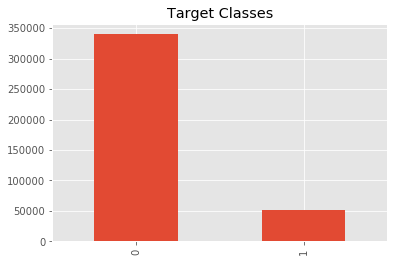

In [100]:
# visualize feature classes to assess if there is imbalance
by_user.purchased.value_counts().plot(kind='bar')
plt.title('Target Classes');

Whoa. The result set is highly skewed with more users that have not purchased, which is in line with what I'd expect for e-commerce data within this window. I will have to take this into account when testing classification methods by stratifying the prediction and over/undersampling.

### Recency, Frequency, Monetary Value
Recency, frequency, and monetary value, commonly known as RFM, is a widely used metric in marketing analytics. This metric aims to group individual users into user segments, or cohorts, based on three factors:
1. **Recency** - The last time the user made a purchase in the store. Since I am aiming to gauge future purchases based on behavior, I am adjusting this metric to reflect the last time the user made an action on the site. This value is represented as the number of days between the current date and the date of the last user action.
2. **Frequency** - How many times the user made a purchase in a given window. Again, I will adjust this metric to include the number of actions taken rather than the number of purchases to better predict future purchases based on all behavior. 
3. **Monetary value** - The total dollar amount of all purchases made by the user. Similar to the other components, the typical RFM calculation will not work here, as we do not know whether the customer has made a purchase or not. To account for this, this value will measure the total value of products the customer has added to their cart.

In [101]:
# run sql query that calculates RFM scores and create dataframe
query = """
WITH monetary_value_calc AS (
    SELECT user_id,
           AVG(added_cart_value) AS monetary_value
    FROM (
         SELECT user_id,
                user_session,
                SUM(price) AS added_cart_value
        FROM all_events
        WHERE (event_type = 'cart') AND (price > 0)
        GROUP BY 1, 2) AS total_value
    GROUP BY 1
),
rfm_raw AS (
    SELECT all_events.user_id,
           EXTRACT(DAY FROM CURRENT_DATE - MAX(event_time)) AS recency,
           COUNT(DISTINCT user_session) AS frequency,
           AVG(monetary_value) AS monetary_value
    FROM all_events
    LEFT JOIN monetary_value_calc
        ON all_events.user_id = monetary_value_calc.user_id
    WHERE event_type != 'remove_from_cart'
    GROUP BY 1
),
rfm_scores AS (
    SELECT rfm_raw.user_id,
           NTILE(5) OVER(ORDER BY recency DESC) AS r,
           NTILE(5) OVER(ORDER BY frequency DESC) AS f,
           NTILE(5) OVER(ORDER BY monetary_value DESC) AS m
    FROM all_events
    JOIN rfm_raw
    ON all_events.user_id = rfm_raw.user_id
)

SELECT DISTINCT user_id,
       CONCAT(r, f, m) AS rfm_score
FROM rfm_scores;
"""
rfm = pd_sql.read_sql(query, connection)

In [102]:
rfm.head()

,user_id,rfm_score
0,1120748,251
1,1458813,341
2,4103071,155
3,5493470,254
4,6217356,355


### Actions per user
Calculate the number of each unique action per user; product views and adds to cart. The total number of purchases was already created when grouping by user, so this step will focus on creating features to quantify the other types of action.

In [103]:
query = """
SELECT user_id,
       SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS num_views,
       SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS adds_to_cart
FROM all_events
GROUP BY 1;
"""
actions = pd_sql.read_sql(query, connection)

In [104]:
actions.head()

,user_id,num_views,adds_to_cart
0,1120748,1,0
1,1458813,31,0
2,4103071,7,1
3,5493470,5,5
4,6217356,0,1


### Add to cart rate
This feature is the measure of how often a customer added a product to their cart when they visited the store. This is a measure of customer intent and may be an indicator of future purchasing.

In [106]:
query = """
WITH cart_sessions AS (
    SELECT all_events.user_id,
           add_to_cart_sessions,
           COUNT(user_session) AS total_sessions
    FROM all_events
    JOIN (
        SELECT user_id,
               COUNT(user_session) add_to_cart_sessions
        FROM all_events
        WHERE event_type = 'cart'
        GROUP BY 1) AS adds_to_cart
        ON all_events.user_id = adds_to_cart.user_id
    GROUP BY 1, 2
)
SELECT user_id,
       CASE WHEN total_sessions = 0 THEN 0 ELSE
           ROUND(CAST(add_to_cart_sessions AS decimal) / total_sessions, 2) END AS add_to_cart_rate
FROM cart_sessions;
"""
add_to_cart = pd_sql.read_sql(query, connection)

In [109]:
add_to_cart.head()

,user_id,add_to_cart_rate
0,4103071,0.13
1,5493470,0.50
2,6217356,1.00
3,8846226,0.51
4,9794320,0.31


### Brand segmentation
Segmentation by brand may give insight into particular affinities for each customer. 
To model this in the data, I will create features for each brand based on each user's individual percentage of total views and percentage of total adds to cart for each brand. These features alongside the users' total views and adds to cart may give the model insight into particular thresholds for brand affinity that entices a customer to eventually make a purchase.

In [110]:
query = """
WITH brand_totals AS (
    SELECT user_id,
           COALESCE(brand, 'other') AS brand,
           SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) AS num_views_per_brand,
           SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) AS num_carts_per_brand
    FROM all_events
    GROUP BY 1, 2
),
user_totals AS (
    SELECT DISTINCT user_id,
                    COALESCE(brand, 'other') AS brand,
                    SUM(CASE WHEN event_type = 'view' THEN 1 ELSE 0 END) OVER(PARTITION BY user_id) AS user_views,
                    SUM(CASE WHEN event_type = 'cart' THEN 1 ELSE 0 END) OVER(PARTITION BY user_id) AS user_carts
    FROM all_events
)
SELECT brand_totals.user_id,
       brand_totals.brand,
       CASE WHEN user_views = 0 THEN 0 ELSE
           ROUND(CAST(num_views_per_brand AS decimal) / user_views, 2) END AS perc_user_views,
       CASE WHEN user_carts = 0 THEN 0 ELSE
           ROUND(CAST(num_carts_per_brand AS decimal) / user_carts, 2) END AS perc_user_carts
FROM brand_totals
JOIN user_totals
    USING(user_id, brand);
"""
brand_dist = pd_sql.read_sql(query, connection)

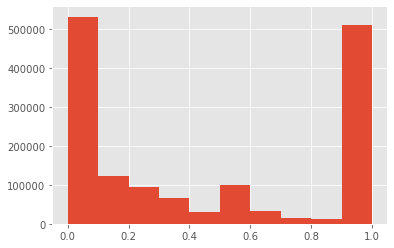

In [111]:
brand_dist.perc_user_views.hist();

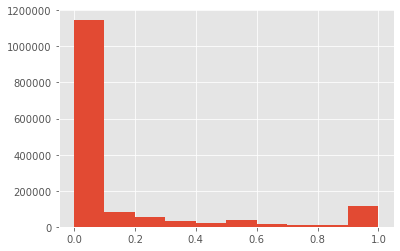

In [112]:
brand_dist.perc_user_carts.hist();

In [113]:
brand_dist.head()

,user_id,brand,perc_user_views,perc_user_carts
0,10280338,other,0.26,0.19
1,13392135,cosmoprofi,0.21,0.33
2,13392135,runail,0.07,0.11
3,14297993,other,0.39,1.00
4,15811955,other,1.00,0.00


In [114]:
# group by user_id and brand in order to unstack index and get individual columns per brand
group_user_categories = brand_dist.groupby(['user_id', 'brand']).mean()

In [115]:
# unstack the dataframe and create separate columns for each brand; fill nulls with zero
brand_unstack = group_user_categories.unstack(level=-1).fillna(0)

In [116]:
# user a list comprehension to create unique feature names for each brand + metric
brand_unstack.columns = ['_'.join(col) for col in brand_unstack.columns]

In [117]:
# drop the "other" category columns in the perc_user_views and perc_user_charts
brand_metrics = brand_unstack.drop(['perc_user_views_other', 'perc_user_carts_other'], axis=1)

In [128]:
brand_metrics.head()

,perc_user_views_airnails,perc_user_views_almea,perc_user_views_andrea,perc_user_views_ardell,perc_user_views_art-visage,perc_user_views_artex,perc_user_views_aura,perc_user_views_australis,perc_user_views_balbcare,perc_user_views_barbie,...,perc_user_carts_vl-gel,perc_user_carts_voesh,perc_user_carts_vosev,perc_user_carts_weaver,perc_user_carts_yoko,perc_user_carts_ypsed,perc_user_carts_yu-r,perc_user_carts_zab,perc_user_carts_zeitun,perc_user_carts_zinger
user_id,,,,,,,,,,,,,,,,,,,,,
1120748,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458813,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4103071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5493470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6217356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now this is quite a bit of features, but what if this is all noise? What if the brand itself that drew the attention of each customer didn't matter at all, rather the fact that the customer directed attention toward any brand in the fashion that they did. To simulate this and roll up the data, I will also include a single value for the percent of views and the percent of adds to cart for each customer that takes the maximum value for each customer from the distribution of brands.

In [137]:
max_vals = brand_dist.groupby('user_id', as_index=False).max()

,user_id,brand,perc_user_views,perc_user_carts
0,1120748,runail,1.00,0.0
1,1458813,other,0.68,0.0
2,4103071,severina,0.43,1.0
3,5493470,runail,0.60,0.6
4,6217356,other,0.00,1.0
...,...,...,...,...
713095,579967088,lovely,1.00,0.0
713096,579968012,irisk,1.00,0.0
713097,579968623,other,1.00,0.0
713098,579968937,other,1.00,0.0


In [139]:
# drop the brand columns
max_vals = max_vals.drop('brand', axis=1)

In [143]:
# rename the columns to avoid confusion with brand columns created from metrics
max_vals = max_vals.rename(columns={'perc_user_views': 'max_perc_user_views', 'perc_user_carts': 'max_perc_user_carts'})
max_vals.head()

,user_id,max_perc_user_views,max_perc_user_carts
0,1120748,1.00,0.0
1,1458813,0.68,0.0
2,4103071,0.43,1.0
3,5493470,0.60,0.6
4,6217356,0.00,1.0


Now the dataset will include a measure of a customers' affinity to view or add products to cart of particular brands. Let's see how this impacts the overall classification of each customer.

<a id='export'></a>
## Merge DataFrames and Export
Merge dataframes created with new features to the original, grouped dataframe. Export the resulting dataframe as the dataset to run models for classification.

In [144]:
# merge rfm scores onto grouped dataframe
users = by_user.merge(rfm, on='user_id')

In [145]:
# merge user actions data
users = users.merge(actions, on='user_id')

In [146]:
# merge add to cart rate data
users = users.merge(add_to_cart, how='left', on='user_id')

In [147]:
# merge brand segmentation metrics to create final modeling set
users = users.merge(brand_metrics, how='left', on='user_id')

In [148]:
users = users.merge(max_vals, how='left', on='user_id')

The percentage metrics (add to cart rate, user views %, and add to cart %) produced nulls due to the left joins in order to preserve customers that may not have added to their cart. To reflect the customers' that did not add to their cart, I will fill all null values with zero. 

In [149]:
# fill null values with zero
users = users.fillna(0)

Finally, I will need to drop the number of purchases metric to prevent data leakage in my models.

In [150]:
users = users.drop('num_purchases', axis=1)

In [151]:
print(users.shape)
users.head()

(394183, 496)


,user_id,purchased,rfm_score,num_views,adds_to_cart,add_to_cart_rate,perc_user_views_airnails,perc_user_views_almea,perc_user_views_andrea,perc_user_views_ardell,...,perc_user_carts_vosev,perc_user_carts_weaver,perc_user_carts_yoko,perc_user_carts_ypsed,perc_user_carts_yu-r,perc_user_carts_zab,perc_user_carts_zeitun,perc_user_carts_zinger,max_perc_user_views,max_perc_user_carts
0,1458813,0,341,31,0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.68,0.00
1,4103071,0,155,7,1,0.13,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.43,1.00
2,5493470,0,254,5,5,0.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.60,0.60
3,8846226,0,143,7,24,0.51,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57,0.33
4,9478445,0,241,4,0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.00


In [152]:
# export dataframe to pickle file to easily import in modeling notebook
with open('users.pickle', 'wb') as outfile:
    pickle.dump(users, outfile)